In this notebook I'll explore the sequence features from Green or Sequoia, aiming to add more accuracy to the prediction.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
import os
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

In [2]:
import nzcompetition

User shya successfully authenticated


# Data

In [3]:
X_raw, y_train, _ = nzcompetition.get_raw_data(target=['performance', 'odor'])

X_raw, y_train = nzcompetition.drop_dup(X_raw, y_train)

In [4]:
transformer = nzcompetition.Transformer(
    use_seq_mut_feature=False, 
    use_seq_prot_feature=False, 
    use_org_feature=False
)
X = transformer.fit_transform(X_raw)
X = pd.DataFrame(X, columns=transformer.df_columns_, index=transformer.df_index_)
y = y_train.reindex(X.index)
y.columns = ['performance', 'odor']

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:228: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)


Currently `X` is the transformed X (from numeric feature and categorical feature), with the sequence-duplicated record removed. And `y` is the corresponding outcomes (2 variables, `performance` and `odor`.

In [5]:
seq_columns = [
    'AA_Sequence', 
    'Mutations_on_Lipolase_Backbone',
    'Mutations_on_MML_Backbone', 
]
X_seq_raw = X_raw[seq_columns].copy().reindex(X.index)

In [6]:
X_seq = nzcompetition.transform.seqtransform.transform_mutations(X_seq_raw)

`X_seq` is the temporary result from basic transformation in last notebook. The value is already scaled.

In [7]:
X_seq.sample(5)

is_from_lipolase  \
Organism Code purifiedsample_sequoia_identifier                     
MML0223       U1R4F                                           0.0   
MML1020       U2H5C                                           0.0   
MML1094       U1Z7Z                                           0.0   
MML1021       U2JC8                                           0.0   
TLL44884      U2HKD                                           1.0   

                                                 is_from_mml  \
Organism Code purifiedsample_sequoia_identifier                
MML0223       U1R4F                                      1.0   
MML1020       U2H5C                                      1.0   
MML1094       U1Z7Z                                      1.0   
MML1021       U2JC8                                      1.0   
TLL44884      U2HKD                                      0.0   

                                                 muts_count_on_backbone  
Organism Code purifiedsample_sequoia_identifier                          
MML0223       U1R4F                                           -0.650743  
MML1020       U2H5C                                            0.207534  
MML1094       U1Z7Z                                           -0.221604  
MML1021       U2JC8                                            0.207534  
TLL44884      U2HKD                                           -0.221604

# Data

## Sequoia Features

We need to start from sequoia features as the index we can use is Sequoia's purification id.

In [8]:
from libdl.dl import dl

### Purification Table

In [9]:
# columns from uid to protein
u_cols = [
    # "purifiedsample_sequoia_identifier" is the index
    'purifiedsample_sequoia_identifier', 
    # more protein info can be found in sequoia P table and Green by this id
    'protein_sequoia_identifiers',
    'mw',
    'theoretical_pi', 
]

The cell below lists columns in organism related feature engineering.

In [10]:
u_df = (
    dl.sequoia.purifiedsample.filter(
        purifiedsample_sequoia_identifier__in=X_seq.index.get_level_values(1)
    )
    .as_df()[u_cols]
    .rename(columns={
        'purifiedsample_sequoia_identifier': 'u_id', 
        'protein_sequoia_identifiers': 'p_id', 
        'mw': 'molweight_u', 
        'theoretical_pi': 'pI_u'
    })
    .set_index('u_id')
    # very strange to use a list in every cell, fix it
    .applymap(lambda s: s[0] if s else np.nan)
)

Mind that there are null in every column.

### Protein Table

In [11]:
[col for col in dl.sequoia.purifiedsample.columns if 'seq' in str.lower(col)]

['construct_sequoia_identifier',
 'copy_of_purified_sample_sequoia_identifier',
 'cultivated_from_sequoia_identifier',
 'cultivated_sample_sequoia_identifier',
 'dna_proteins_sequoia_identifiers',
 'from_culturedsample_sequoia_identifier',
 'from_prioritized_culturedsample_sequoia_identifier',
 'from_purifiedsample_sequoia_identifier',
 'gene_donor_sequoia_identifiers',
 'library_sequoia_identifier',
 'obtained_from_purifiedsample_sequoia_identifier',
 'organism_cultivated_from_sequoia_identifier',
 'parent_cultivatedsample_sequoia_identifier',
 'protein_sequoia_identifiers',
 'purified_from_purified_sample_sequoia_identifier',
 'purified_protein_sequoia_identifier',
 'purifiedsample_sequoia_identifier',
 'recombinant_protein_sequoia_identifiers',
 'source_contract_sequoia_identifier',
 'source_sequoia_identifier',
 'modified_samples_sequoia_identifier',
 'other_protein_sequence_reference_identifier']

In [12]:
p_cols = [
    'protein_sequoia_identifier', 
    'charge', 
#    # mind that here is also the donor information, which can be used in org features
#    'donor_organism_scientific_name', 
#    'donor_organism_sequoia_identifier', 
    'molweight',
    'pi',
]

In [13]:
p_df = (
    dl.sequoia.protein.filter(
        protein_sequoia_identifier__in=u_df['p_id'].dropna()
    ).as_df()[p_cols]
    .rename(columns={
        'protein_sequoia_identifier': 'p_id', 
        'molweight': 'molweight_p', 
        'pi': 'pI_p'
    })
    .set_index('p_id')
)

Now we have `u_df` and `p_df`, which are protein related information from sequoia. We can use the `p_id` to search for other features from Green.

## Green Features

In [14]:
from libgreen.models import (
    Protein, 
    # don't know how to use the ProteinStructure
#    ProteinStructure, 
)

In [15]:
qterms = '({}) {}'.format(' OR '.join(p_df.index), 'AND database:NZPROT')
green_pids = Protein.search(qterms)

In [16]:
green_df = pd.DataFrame(index=green_pids, columns=['p_id', 'activity', 'module_string', 'pI_green', 'cosq'])

In [17]:
for pid in green_df.index:
    p = Protein.get(pid)
    green_df.loc[pid, :] = (
        p.sequoia.split(',')[1], 
        p.activity, 
        p.module_string(), 
        p.pi_without_signal, 
        p.cosq
    )

In [18]:
green_df = green_df.set_index('p_id')
green_df['pI_green'] = green_df['pI_green'].astype(np.float64)
green_df['cosq'] = green_df['cosq'].astype(np.float64)

In [19]:
green_df.cosq.isna().sum()

43

Note that cosq has missing data.

# Preprocess

## Combine data

Now we have 3 `DataFrame`, we can combine them to one and unify some common features.

In [20]:
protdf = (
    u_df.reset_index().set_index('p_id')
    .join(p_df)
    .join(green_df)
    .set_index('u_id')
)

In [21]:
protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
protdf = protdf.drop(columns=['pI_u', 'pI_p', 'pI_green'])

protdf['molweight'] = np.nanmean(protdf[['molweight_u', 'molweight_p']], axis=1)
protdf = protdf.drop(columns=['molweight_u', 'molweight_p'])

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [22]:
protdf.shape

(122, 6)

## Activity

In [23]:
actDct = {}
for acts in protdf['activity'].dropna():
    for act in acts.split(';'):
        if act not in actDct:
            actDct[act] = 1
        else:
            actDct[act] += 1

In [24]:
pd.Series(actDct)

Alpha/beta hydrolase family     87
Lipase (EC 3.1.1.3)            117
Lipase (class 3)               117
Lipase 3 N-terminal region     117
SP400-like lipases             117
Serine aminopeptidase, S33      87
dtype: int64

In [25]:
protdf['activity'].notna().sum()

117

In 117 records with `activity` field, only 2 are differentiative. Encode the 2 features as boolean.

In [26]:
protdf['is_ab_hydorlase'] = (
    protdf['activity']
    .apply(lambda s: 'Alpha/beta hydrolase' in s if isinstance(s, str) else False)
)
protdf['is_serine_aminopeptidase'] = (
    protdf['activity']
    .apply(lambda s: 'Serine aminopeptidase' in s if isinstance(s, str) else False)
)
protdf = protdf.drop(columns=['activity'])

In [27]:
protdf.sample()

charge              module_string      cosq      pI  molweight  \
u_id                                                                    
U1NUH    -5.5  [PF03893][SP400][PF01764]  0.975414  4.9416   29397.41   

       is_ab_hydorlase  is_serine_aminopeptidase  
u_id                                              
U1NUH            False                     False

## Module

In [28]:
modDct = {}
for mods in protdf['module_string'].dropna():
    for mod in mods.strip('[]').split(']['):
        if mod not in modDct:
            modDct[mod] = 1
        else:
            modDct[mod] += 1

In [29]:
pd.Series(modDct)

PF01764    117
PF03893    117
PF12146     87
PF12697     87
SP400      117
dtype: int64

In [30]:
protdf['module_string'].notna().sum()

117

In 117 records with `module_string` field, only 2 are differentiative. Encode the 2 features as boolean. Also we need to perform deminsionality reduction as this features could be inter-connected and correlated with the backbone selection.

In [31]:
protdf['has_PF12146'] = (
    protdf['module_string']
    .apply(lambda s: 'PF12146' in s if isinstance(s, str) else False)
)
protdf['has_PF12697'] = (
    protdf['module_string']
    .apply(lambda s: 'PF12697' in s if isinstance(s, str) else False)
)
protdf = protdf.drop(columns=['module_string'])

In [32]:
protdf.sample()

charge  cosq      pI  molweight  is_ab_hydorlase  \
u_id                                                      
U2JCS    -5.0   NaN  5.0342    29064.0             True   

       is_serine_aminopeptidase  has_PF12146  has_PF12697  
u_id                                                       
U2JCS                      True         True         True

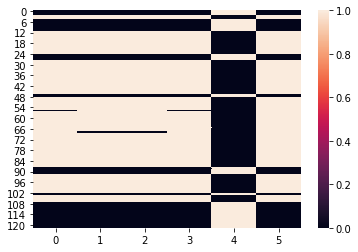

In [33]:
sns.heatmap(np.c_[
    protdf[[
        'is_ab_hydorlase', 
        'is_serine_aminopeptidase', 
        'has_PF12146', 
        'has_PF12697'
    ]].sort_index(), 
    X_seq.reset_index(level=0)[['is_from_lipolase', 'is_from_mml']].sort_index()
])

The module / activity / backbone features are indeed highly correlated. Dimensionality reduction is necessary.

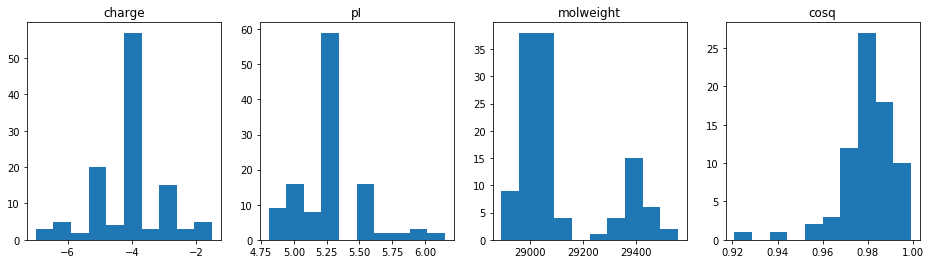

In [34]:
fig = plt.figure(figsize=(16, 4))

for i, col in enumerate(['charge', 'pI', 'molweight', 'cosq']):
    ax = fig.add_subplot(1, 4, i+1)
    ax.hist(protdf[col].dropna())
    ax.set_title(col)

fig.show()

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [36]:
# fill missing and normalize numeric features
imp = SimpleImputer(strategy='mean')
protdf = pd.DataFrame(
    imp.fit_transform(protdf), 
    columns=protdf.columns, 
    index=protdf.index
)

In [37]:
# normalized numeric features
scl = StandardScaler()
protdf[['charge', 'pI', 'molweight', 'cosq']] = (
    scl.fit_transform(protdf[['charge', 'pI', 'molweight', 'cosq']])
)

In [38]:
protdf.sample()

charge      cosq       pI  molweight  is_ab_hydorlase  \
u_id                                                             
U856Y  2.643294 -6.220706  3.43928   2.024287              0.0   

       is_serine_aminopeptidase  has_PF12146  has_PF12697  
u_id                                                       
U856Y                       0.0          0.0          0.0

### Combine features

Now we can combine the sequence features together.

In [39]:
X_prot = (
    pd.DataFrame(index=X_seq.index)
    .reset_index(level=0)
    .join(protdf.rename_axis(index='purifiedsample_sequoia_identifier'))
    .reset_index()
    .set_index(['Organism Code', 'purifiedsample_sequoia_identifier'])
)
X_prot.sample()

charge     cosq        pI  \
Organism Code purifiedsample_sequoia_identifier                                
MML0138       U1QXA                             -1.927131  0.61451 -1.624229   

                                                 molweight  is_ab_hydorlase  \
Organism Code purifiedsample_sequoia_identifier                               
MML0138       U1QXA                              -0.525587              1.0   

                                                 is_serine_aminopeptidase  \
Organism Code purifiedsample_sequoia_identifier                             
MML0138       U1QXA                                                   1.0   

                                                 has_PF12146  has_PF12697  
Organism Code purifiedsample_sequoia_identifier                            
MML0138       U1QXA                                      1.0          1.0

Now we have the final `X_seq`:

In [40]:
X_seq_prot = (
    X_seq
    .reset_index(level=0)
    .join(protdf.rename_axis(index='purifiedsample_sequoia_identifier'))
    .reset_index()
    .set_index(['Organism Code', 'purifiedsample_sequoia_identifier'])
)
X_seq.sample()

is_from_lipolase  \
Organism Code purifiedsample_sequoia_identifier                     
MML0223       U1R4F                                           0.0   

                                                 is_from_mml  \
Organism Code purifiedsample_sequoia_identifier                
MML0223       U1R4F                                      1.0   

                                                 muts_count_on_backbone  
Organism Code purifiedsample_sequoia_identifier                          
MML0223       U1R4F                                           -0.650743

---

Now we can wrap the codes.

---

# Examine benefits for prediction

This part will be constantly refreshed everytime a new feature is generated, just for inspecting prediction results with sequence related features.

### Check feature improvements on prediction

Now we have `X` as the transformed input (only numeric and categorical features) and `y` the corresponding outcomes (2 variables). We need to find out whether adding sequence related features can help prediction. 

Use LinearyRegression/LASSO/Ridge as the example model. Before calling the model we need to reduce the dimension as there are many highly correlated features.

In [41]:
from nzcompetition.metrics import cv_preds_metrics
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [42]:
def corr(y, yhat):
    return np.corrcoef(y, yhat)[0,1]

def diff_variance(y, yhat):
    return np.var(y-yhat)

In [43]:
X_pca = PCA(0.95).fit_transform(X)
X_seq_pca = (
    PCA(0.95)
    .fit_transform(
        np.c_[X, X_seq]
    )
)
X_seq_prot_pca = (
    PCA(0.95)
    .fit_transform(
        np.c_[X, X_seq_prot]
    )
)


In [44]:
metdf = pd.concat([
    cv_preds_metrics(
        Ridge(alpha=1), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_pca, 
        y=y.performance
    ), 
    cv_preds_metrics(
        Ridge(alpha=1), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_seq_pca, 
        y=y.performance
    ), 
    cv_preds_metrics(
        Ridge(alpha=1), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_seq_prot_pca, 
        y=y.performance
    ), 
], ignore_index=False)

metdf.index = [['without_seq']*4+['with_seq']*4+['with_seq_prot']*4, metdf.index]
metdf

mean_squared_error      corr  diff_variance
without_seq   3             0.020118  0.879785       0.020083
              5             0.022116  0.869027       0.021765
              10            0.022351  0.867383       0.022322
              20            0.021839  0.869991       0.021839
with_seq      3             0.020815  0.875529       0.020800
              5             0.023179  0.863059       0.023050
              10            0.023335  0.863883       0.023335
              20            0.022433  0.868842       0.022406
with_seq_prot 3             0.023753  0.858710       0.023746
              5             0.025494  0.850461       0.025406
              10            0.025297  0.853883       0.025296
              20            0.024750  0.856894       0.024709

In [45]:
metdf = pd.concat([
    cv_preds_metrics(
        Ridge(alpha=0.5), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_pca, 
        y=y.odor
    ), 
    cv_preds_metrics(
        Ridge(alpha=0.5), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_seq_pca, 
        y=y.odor
    ), 
    cv_preds_metrics(
        Ridge(alpha=1), 
#        LinearRegression(n_jobs=8), 
        metrics=[mean_squared_error, corr, diff_variance], 
        cv=[3, 5, 10, 20], 
        X=X_seq_prot_pca, 
        y=y.odor
    ), 
], ignore_index=False)

metdf.index = [['without_seq']*4+['with_seq']*4+['with_seq_prot']*4, metdf.index]
metdf

mean_squared_error      corr  diff_variance
without_seq   3             0.805283  0.290620       0.802643
              5             0.644395  0.364971       0.644393
              10            0.559334  0.412707       0.559290
              20            0.433454  0.520228       0.433293
with_seq      3             0.790440  0.297889       0.784932
              5             0.635274  0.384511       0.635261
              10            0.553747  0.419044       0.553743
              20            0.430390  0.520695       0.430371
with_seq_prot 3             0.734663  0.342282       0.726230
              5             0.595837  0.415152       0.595336
              10            0.576661  0.410824       0.576590
              20            0.442995  0.507647       0.442954

No obvious accuracy improvements. The hyperparameters should be carefully selected. 

# Transformation rational

The goal of transformation is: feature engineering for more informative features for prediction.

1. recalculate backbone
1. fix mutation list by correct backbone
1. count mutations (splitting mutation count from mutation list)
1. drop original mutation columns

Then validate if the added features helped prediction.

Further questions:
* What's the secondary structure and functional domains of the backbones?
* What's the relationship of the 2 backbones?
* How many mutations are there? 
* Is there any hot spots?
* What's the grouping of mutations, is there any classification?
* Which mutation or mutation groups correlates with outcomes?
* What will a multiple alignment reveal?

Also we can use the index to search Green for domain information.